In [27]:
import json
import os
import shutil

for root, dirs, files in os.walk('../exp_results/baseline_sampled'):
    if any('checkpoint_00' in d for d in dirs):
        if not any('checkpoint_000110' in d for d in dirs) and not any('checkpoint_000055' in d for d in dirs):
            shutil.rmtree(root)


In [51]:
import json
import os
import re
import numpy as np
import pandas as pd

root_dir = '../exp_results/baseline_correct'

def load_eval_results(path):
    eval_results = []
    with open(path, 'r') as f:
        for line in f:
            data = json.loads(line)
            if 'evaluation' in data:
                eval_results.append(data['evaluation'])

    if len(eval_results) == 0:
        print(path)
    return eval_results

results = []
for alg_name in os.listdir(root_dir):
    for exp_name in os.listdir(os.path.join(root_dir, alg_name)):
        for result_dir in os.listdir(os.path.join(root_dir, alg_name, exp_name)):
            if not 'steps' in result_dir:
                continue

            n_days = int(re.findall('steps=([0-9]+)', result_dir)[0])

            for root, _, files in os.walk(os.path.join(root_dir, alg_name, exp_name, result_dir)):
                if 'result.json' in files:
                    eval_result = load_eval_results(os.path.join(root, 'result.json'))
                    #best_result_id = np.argmax([r['episode_reward_mean'] for r in eval_result])
                    eval_result = eval_result[-1]
                    results.append((alg_name, n_days, eval_result['episode_reward_mean'], eval_result['episode_reward_min'], eval_result['episode_reward_max']))

df = pd.DataFrame(results, columns=['alg_name', 'n_days', 'reward_mean','reward_min','reward_max'])
df = df.sort_values(by=['alg_name', 'n_days'], ascending=[True, True])
df

,alg_name,n_days,reward_mean,reward_min,reward_max
2,DQN,5,3.312600,3.312600,3.312600
1,DQN,10,22.153538,21.374013,23.322825
0,DQN,30,18.752528,14.533179,21.565426
3,DQN,60,80.815915,80.748281,80.917366
4,DQN,120,132.486209,129.267895,134.631752
5,DQN,300,225.319584,205.673605,254.788552
6,DQN,600,262.146919,256.115331,271.194301


In [75]:
import numpy as np

from rl_trading.simulation.env import StockExchangeEnv0
from rl_trading.data.indicators import *

state_config = {
        'market_state': ['vwap'],
        'technical_indicators': [
            (EMA, dict(timeperiod=5, normalize=True), '1min'),
            (EMA, dict(timeperiod=13, normalize=True), '1min'),
            (RSI, dict(timeperiod=7, normalize=True), '1min'),
            (BBANDS, dict(timeperiod=10), '1min'),
            (EMA, dict(timeperiod=20, normalize=True), '1h'),
            (EMA, dict(timeperiod=50, normalize=True), '1h'),
            (RSI, dict(timeperiod=14, normalize=True), '1h'),
            (BBANDS, dict(timeperiod=20), '1h'),
            (MACD_DIFF, dict(fastperiod=12, slowperiod=26, signalperiod=9, normalize=True), '1h'),
            (EMA, dict(timeperiod=50, normalize=True), '1d'),
            (EMA, dict(timeperiod=200, normalize=True), '1d'),
            (RSI, dict(timeperiod=14, normalize=True), '1d'),
            (BBANDS, dict(timeperiod=20), '1d'),
            (MACD_DIFF, dict(fastperiod=12, slowperiod=26, signalperiod=9, normalize=True), '1d'),
        ]}

optimal_rewards = {} if not os.path.exists('optimal_rewards.json') else json.load(open('optimal_rewards.json'))
for n_days in [1, 2, 3, 7, 14, 30, 90, 180, 365, 500, 1000]:
    if n_days in optimal_rewards:
        continue
    idxs = np.linspace(288000, 2792281 - 1440 - 1, n_days, dtype=int)
    rewards = []
    for idx in idxs:
        env = StockExchangeEnv0(state_config=state_config, _idxs_range=[idx])

        env.reset()
        done = False
        reward_total = 0
        while not done:
            current_idx = env.current_idx
            current_price = env.price_data['1min'][current_idx]
            next_price = env.price_data['1min'][current_idx + 1]
            if next_price > current_price:
                action = 1
            elif next_price < current_price:
                action = 2
            else:
                action = 0
            state, reward, done, _, _ = env.step(action)
            reward_total += reward
        rewards.append(reward_total)
    print(f'Rewards for {n_days} days: {np.mean(rewards)}')
    optimal_rewards[n_days] = np.mean(rewards)


print(optimal_rewards)

Rewards for 500 days: 5454.563166184455
Rewards for 1000 days: 5128.838670710063
{1: 3524.0318073657327, 2: 2448.108463408131, 3: 2196.5172885797583, 7: 4578.045584805158, 14: 5281.126865380163, 30: 5046.436411228319, 90: 5209.73555386386, 180: 5561.167910107364, 365: 4924.183543495301, 500: 5454.563166184455, 1000: 5128.838670710063}


In [84]:
for n_days, return_ in optimal_rewards.items():
    df.loc[df['n_days'] == n_days,['reward_mean','reward_min','reward_max']] = df[df['n_days'] == n_days][['reward_mean','reward_min','reward_max']] / return_ * 100

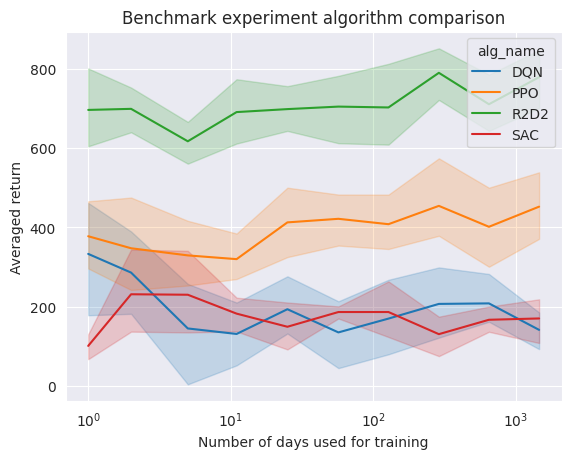

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x='n_days', y='reward_mean', hue='alg_name', data=df)
plt.xscale('log')
plt.xlabel('Number of days used for training')
plt.ylabel('Averaged return')
plt.title('Benchmark experiment algorithm comparison')
plt.savefig('benchmark_exp.pdf')

In [47]:
np.geomspace(5, 1440, 7, dtype=int, endpoint=False)

array([  5,  11,  25,  56, 127, 285, 641])

0.003472222222222222

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    1,    2,
          4,    8,   15,   30,   57,  109,  209,  399,  764, 1460])